In [80]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from statistics import mode

In [2]:
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Null",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Knocking",
    "Phone vibrating"
]

configuration = tflscripts.read_configuration()
activities_i = [configuration['activities'].index(a) for a in activities]

use_features = "^(?!mag|light)"

In [3]:
dataset = 'synergy-final-iter1-2s'
device = '128.237.254.195'

df, df_labels = tflscripts.read_and_filter_dataset(
        dataset,
        device,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

for label in df_labels.label.unique():
    df_labels_modified = df_labels.copy()
    df_labels_modified.loc[df_labels.label != label, 'label'] = -1

    dfs = tflscripts.take_multiple_percentages_of_data(
            df, df_labels_modified,
            [0.7, 0.3])

    X_train, y_train = dfs[0]
    X_test, y_test = dfs[1]

    y_train = y_train['label']
    y_test = y_test['label']

    ppl = Pipeline([
        ('impute', Imputer()),
        ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr', probability=True))
    ])

    ppl.fit(X_train, y_train)

    predicted = ppl.predict(X_test)
    proba = pd.DataFrame(ppl.predict_proba(X_test))
    proba.columns = [-1, label]
    [1]
    plt.show()

    accuracy = accuracy_score(y_test, predicted)
    print(configuration['activities'][label], accuracy)

Null 0.914634146341
Microwave 0.969512195122
Kettle 0.859756097561
Chopping food 0.947154471545
Coffee 0.841463414634
Dishes 1.0
Conversation 0.947154471545
Eating popcorn 0.928861788618
Phone vibrating 0.930894308943
Knocking 0.99593495935


In [95]:
def smooth_predictions(predicted):
    smoothed = []

    for i, prediction in enumerate(predicted):
        next_disagreements = [p for p in predicted[i:min(len(predicted), i + 3)] if p != prediction]
        if len(next_disagreements) == 0:
            smoothed.append(prediction)
        else:
            try:
                window = predicted[max(0, i - 3):min(len(predicted), i + 3)]
                smoothed.append(mode(window))
            except:
                try:
                    smoothed.append(mode([p for p in window if p != -1]))
                except:
                    smoothed.append(prediction)

#         true_before = len([p for p in predicted[max(0, i - 3):i] if p != -1])
#         true_after = len([p for p in predicted[i:min(len(predicted), i + 3)] if p != -1])

#         if true_before == 0 and true_after == 0:
#             smoothed.append(-1)
#         elif true_before > 1 and is_true:
#             smoothed.append(label)
#         elif true_after > 1 and is_true:
#             smoothed.append(label)
#         elif true_before > 1 and true_after > 0:
#             smoothed.append(label)
#         elif true_before > 0 and true_after > 1:
#             smoothed.append(label)
#         else:
#             smoothed.append(-1)

    return smoothed

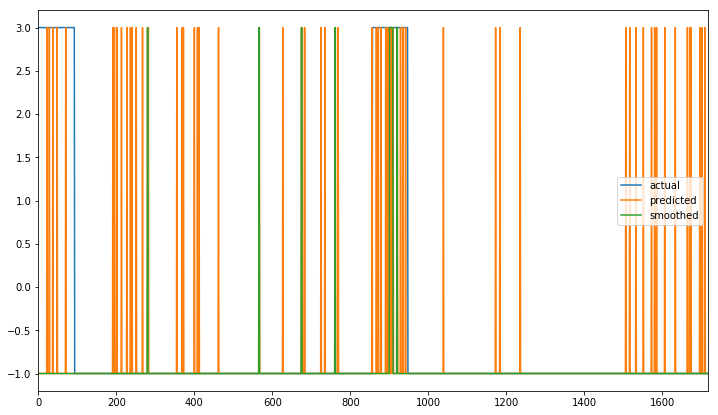

Null 0.896451425247


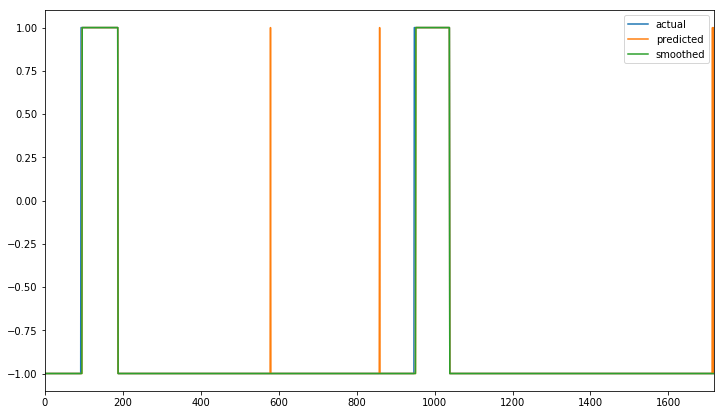

Microwave 0.995927865038


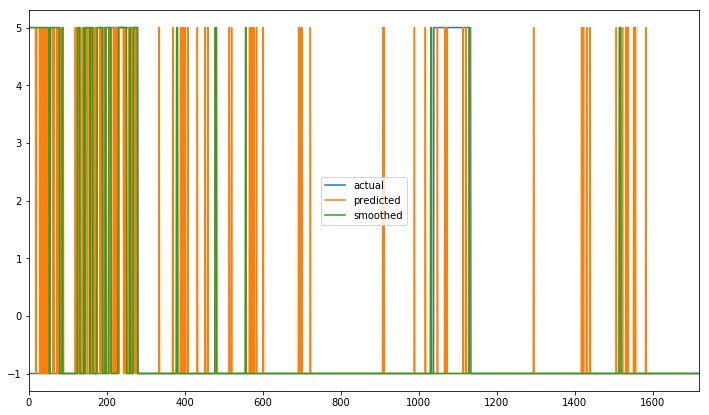

Kettle 0.841768470041


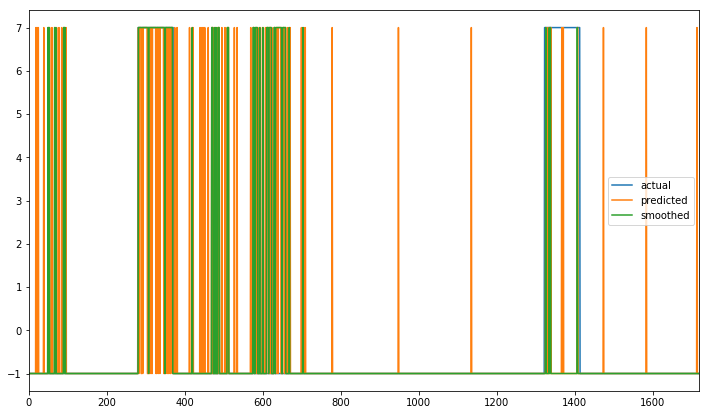

Chopping food 0.902268760908


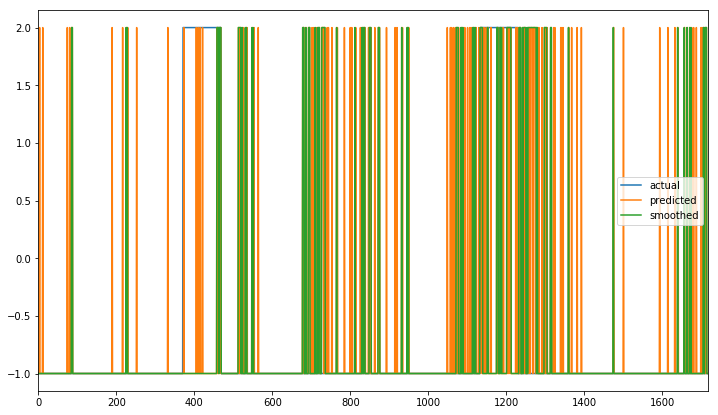

Coffee 0.823734729494


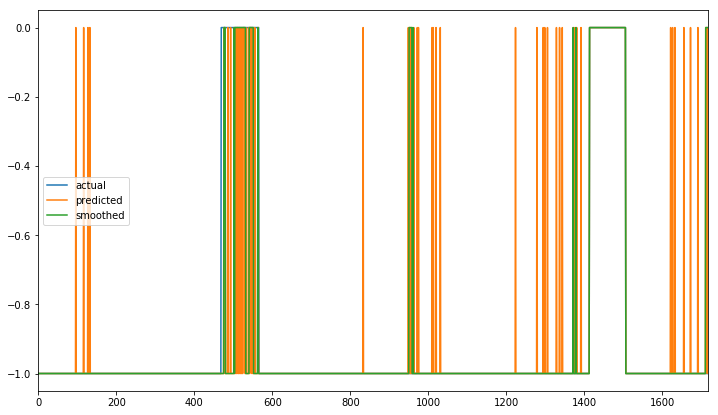

Dishes 0.959278650378


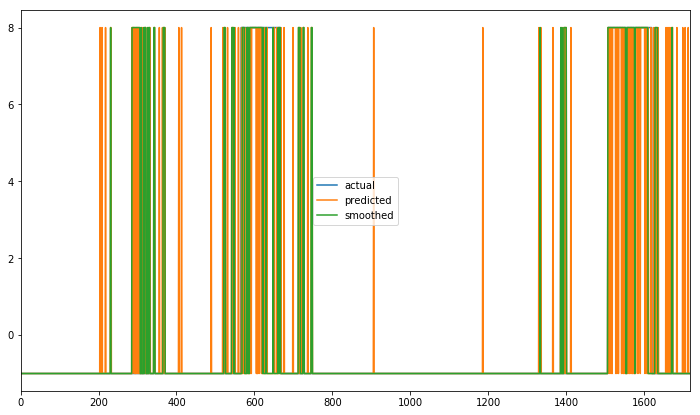

Conversation 0.914485165794


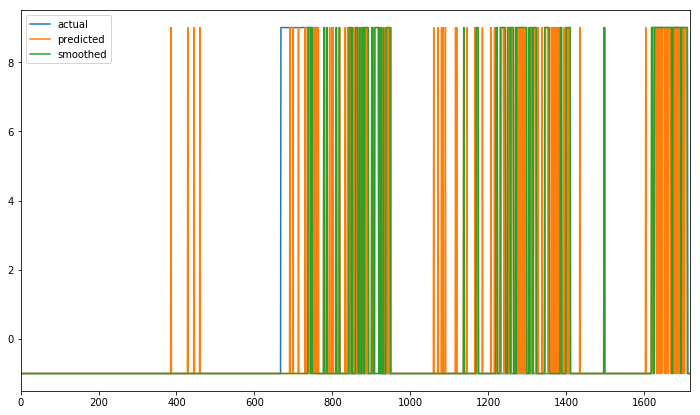

Eating popcorn 0.842931937173


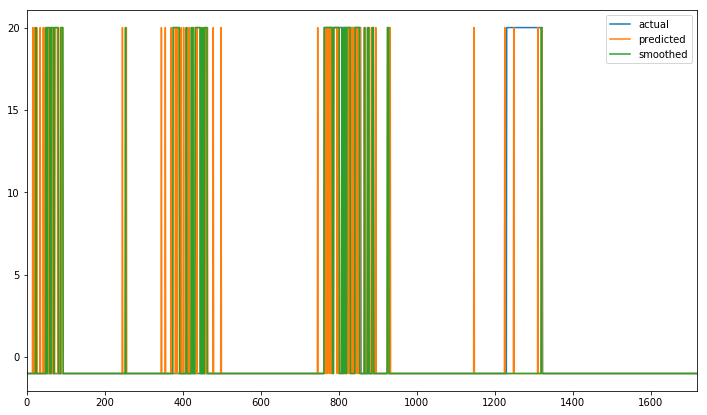

Phone vibrating 0.874927283304


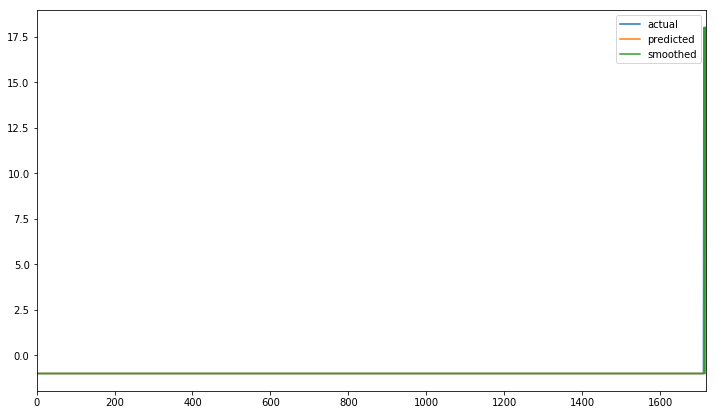

Knocking 0.998254799302


In [31]:
source_dataset = 'synergy-final-iter1'
source_device = 'Matrix b827eb41f96f'
target_dataset = 'synergy-final-iter2'
target_device = 'Matrix b827ebe6e0f8'

df_source, df_source_labels = tflscripts.read_and_filter_dataset(
        source_dataset + '-2s',
        source_device,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

df_target, df_target_labels = tflscripts.read_and_filter_dataset(
        target_dataset + '-2s',
        target_device,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

df_source = df_source.loc[df_source.index.isin(df_source_labels.index)]
df_target = df_target.loc[df_target.index.isin(df_target_labels.index)]

df_source_labels = df_source_labels.loc[df_source_labels.index.isin(df_source.index)]
df_target_labels = df_target_labels.loc[df_target_labels.index.isin(df_target.index)]

for label in df_source_labels.label.unique():
    df_source_labels_modified = df_source_labels.copy()
    df_source_labels_modified.loc[df_source_labels_modified.label != label, 'label'] = -1

    df_target_labels_modified = df_target_labels.copy()
    df_target_labels_modified.loc[df_target_labels_modified.label != label, 'label'] = -1

    y_train = df_source_labels_modified['label']
    y_test = df_target_labels_modified['label']

    ppl = Pipeline([
        ('impute', Imputer()),
        ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr'))
    ])

    ppl.fit(df_source, y_train)

    predicted = ppl.predict(df_target)
    smoothed = smooth_predictions(predicted, label)
    proba = pd.DataFrame({'predicted': predicted, 'smoothed': smoothed, 'actual': y_test.values})
    proba.plot()
    plt.show()

    accuracy = accuracy_score(y_test, smoothed)
    print(configuration['activities'][label], accuracy)

In [99]:
def get_y_for_label(df_labels, label):
    df_labels_modified = df_labels.copy()
    df_labels_modified.loc[df_labels_modified.label != label, 'label'] = -1
    return df_labels_modified['label']


class PipelineWrapper:
    def __init__(self, ppl, label, columns,
                 source_device=None,
                 source_dataset=None,
                 source_name=None):
        self.ppl = ppl
        self.label = label
        self.columns = columns
        self.source_device = source_device
        self.source_dataset = source_dataset
        self.source_name = source_name
        self.label_name = configuration['activities'][label]


training_devices = [
    ['synergy-final-iter1', '128.237.254.195', 'Synergy 1 sink'], # sink
    ['synergy-final-iter1', '128.237.246.127', 'Synergy 1 coffee'], # coffee
    ['synergy-final-iter1', '128.237.248.186', 'Synergy 1 table'], # table
    ['synergy-final-iter2', '128.237.248.186', 'Synergy 2 sink'], # sink
    ['synergy-final-iter2', '128.237.254.195', 'Synergy 2 coffee'], # coffee
    ['synergy-final-iter2', '128.237.246.127', 'Synergy 2 table'], # table
#     ['synergy-final-iter3', '128.237.237.122', 'Synergy 3 sink'], # sink
#     ['synergy-final-iter3', '128.237.239.234', 'Synergy 3 coffee'], # coffee
#     ['synergy-final-iter3', '128.237.234.0', 'Synergy 3 table'], # table
    ['scott-final-iter1', '128.237.248.186', 'Scott 1 left'], # left
    ['scott-final-iter1', '128.237.247.134', 'Scott 1 right'], # right
    ['robotics-final', '128.237.246.127', 'Robotics coffee'], # coffee
    ['robotics-final', '128.237.247.134', 'Robotics sink'], # sink
    ['robotics-final', '128.237.248.186', 'Robotics entrance'], # entrance
]
testing_devices = [
    ['synergy-final-iter1', '128.237.254.195', 'Synergy 1 sink'], # sink
    ['synergy-final-iter1', '128.237.246.127', 'Synergy 1 coffee'], # coffee
    ['synergy-final-iter1', '128.237.248.186', 'Synergy 1 table'], # table
    ['synergy-final-iter2', '128.237.248.186', 'Synergy 2 sink'], # sink
    ['synergy-final-iter2', '128.237.254.195', 'Synergy 2 coffee'], # coffee
    ['synergy-final-iter2', '128.237.246.127', 'Synergy 2 table'], # table
#     ['synergy-final-iter3', '128.237.237.122', 'Synergy 3 sink'], # sink
#     ['synergy-final-iter3', '128.237.239.234', 'Synergy 3 coffee'], # coffee
#     ['synergy-final-iter3', '128.237.234.0', 'Synergy 3 table'], # table
    ['scott-final-iter1', '128.237.248.186', 'Scott 1 left'], # left
    ['scott-final-iter1', '128.237.247.134', 'Scott 1 right'], # right
    ['robotics-final', '128.237.246.127', 'Robotics coffee'], # coffee
    ['robotics-final', '128.237.247.134', 'Robotics sink'], # sink
    ['robotics-final', '128.237.248.186', 'Robotics entrance'], # entrance
]
pipelines = []


for source in training_devices:
    source_dataset = source[0]
    source_device = source[1]
    source_name = source[2]

    df_source, df_source_labels = tflscripts.read_and_filter_dataset(
            source_dataset + '-1s',
            source_device,
            use_features='.*',
            use_activities=activities_i,
            scale=True,
            with_feature_selection=False)

    df_source = df_source.loc[df_source.index.isin(df_source_labels.index)]
    df_source_labels = df_source_labels.loc[df_source_labels.index.isin(df_source.index)]

    for label in df_source_labels.label.unique():
        y_train = get_y_for_label(df_source_labels, label)

        ppl = Pipeline([
            ('impute', Imputer()),
            ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr'))
        ])

        ppl.fit(df_source, y_train)
        pipelines.append(PipelineWrapper(label=label,
                                         ppl=ppl,
                                         source_device=source_device,
                                         source_dataset=source_dataset,
                                         source_name=source_name,
                                         columns=df_source.columns))

In [114]:
test_results = {}

for target in testing_devices:
    target_dataset = target[0]
    target_device = target[1]
    target_name = target[2]
    print(target_name)

    label_pipelines = {}

    df_target, df_target_labels = tflscripts.read_and_filter_dataset(
        target_dataset + '-1s',
        target_device,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

    df_target = df_target.loc[df_target.index.isin(df_target_labels.index)]

    for pipeline in pipelines:
        if pipeline.source_name == target_name:
            continue

        y_test = get_y_for_label(df_target_labels, pipeline.label)
        x_test = df_target[pipeline.columns]

        x_false = x_test[y_test == -1]
        y_false = y_test[y_test == -1]

        false_predicted = pipeline.ppl.predict(x_false)
        false_predicted = smooth_predictions(false_predicted)

        accuracy = accuracy_score(y_false, false_predicted)

        if accuracy >= 0.95:
            if pipeline.label in label_pipelines:
                label_pipelines[pipeline.label].append({
                    'accuracy': accuracy,
                    'pipeline': pipeline
                })
            else:
                label_pipelines[pipeline.label] = [{
                    'accuracy': accuracy,
                    'pipeline': pipeline
                }]

    results = []
    result_accuracies = []
    for label in label_pipelines:
        ppls = label_pipelines[label]
        ppls = sorted(ppls, key=lambda x: x['accuracy'], reverse=True)

        for ppl in ppls[:1]:
            pipeline = ppl['pipeline']

            x_test = df_target[pipeline.columns]

            predicted = pipeline.ppl.predict(x_test)

            results.append(predicted)
            result_accuracies.append(ppl['accuracy'])

    results = np.array(results)
    results = results.T
    
    predicted = []
    for row in results:
        prediction_accuracies = [[p, result_accuracies[i]] for i, p in enumerate(row) if p != -1]

        if len(prediction_accuracies) > 0:
            prediction_accuracies = sorted(prediction_accuracies,
                                          key=lambda x: x[1],
                                          reverse=True)
            prediction = prediction_accuracies[0][0]
            predicted.append(prediction)
            continue

        predicted.append(-1)

    all_predictions = pd.DataFrame({
        'predicted': smooth_predictions(predicted),
        'actual': df_target_labels['label'].values
    })
    test_results[target_name] = all_predictions

Synergy 1 sink
Synergy 1 coffee
Synergy 1 table
Synergy 2 sink
Synergy 2 coffee
Synergy 2 table
Scott 1 left
Scott 1 right
Robotics coffee
Robotics sink
Robotics entrance


Synergy 1 sink 0.926689576174


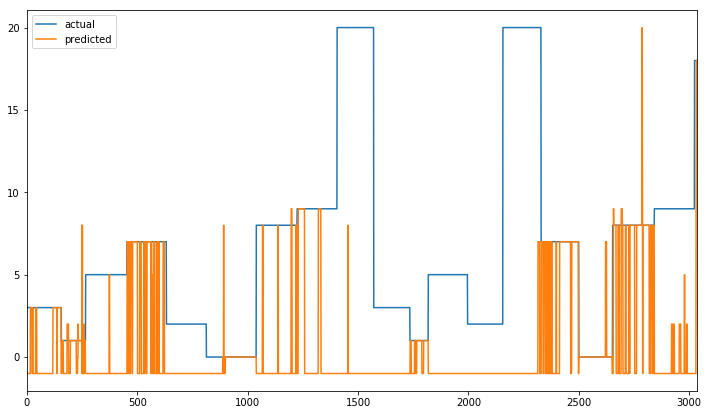

Robotics coffee 0.890162368672


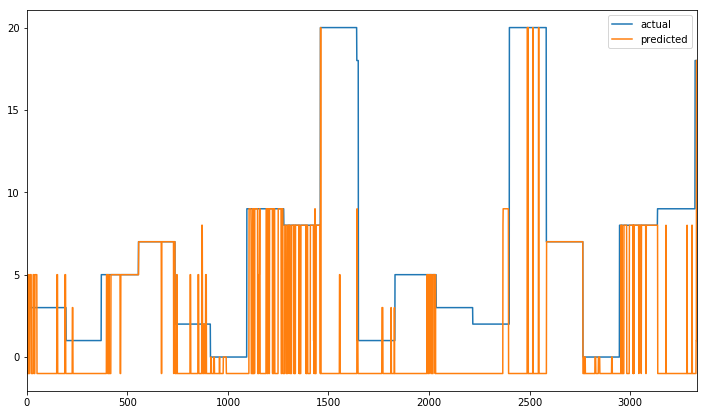

Synergy 2 sink 0.960125097733


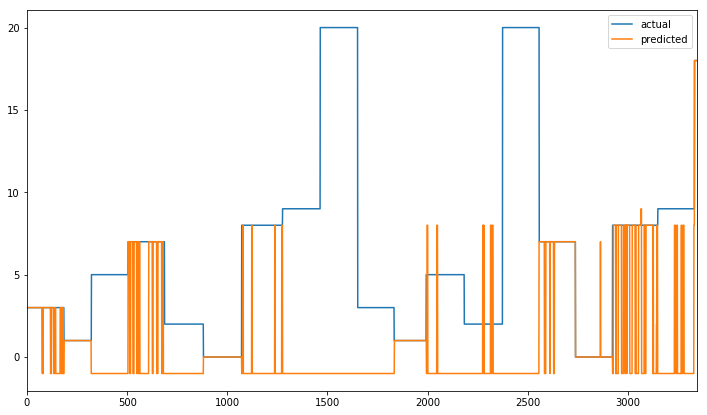

Scott 1 right 0.942006269592


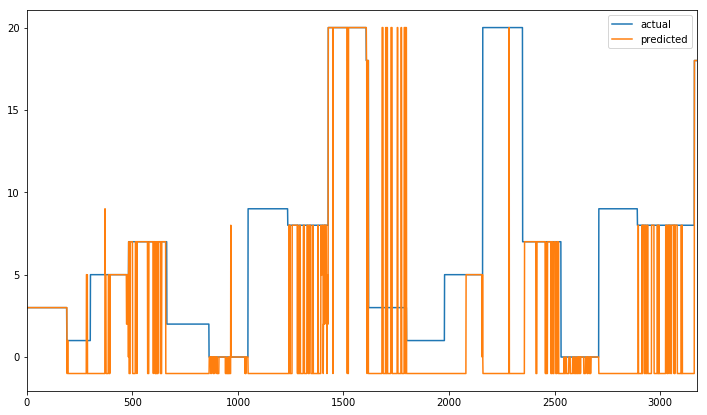

Robotics sink 0.887837837838


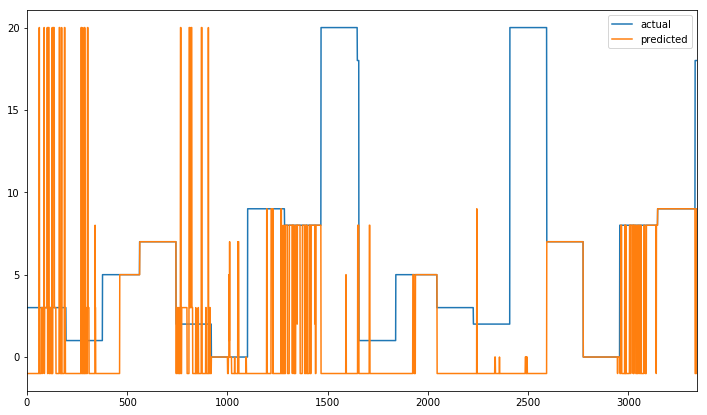

Synergy 1 coffee 0.931880108992


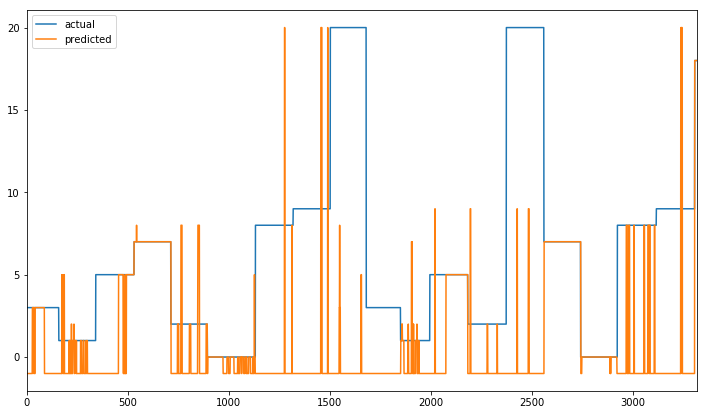

Synergy 2 table 0.911522633745


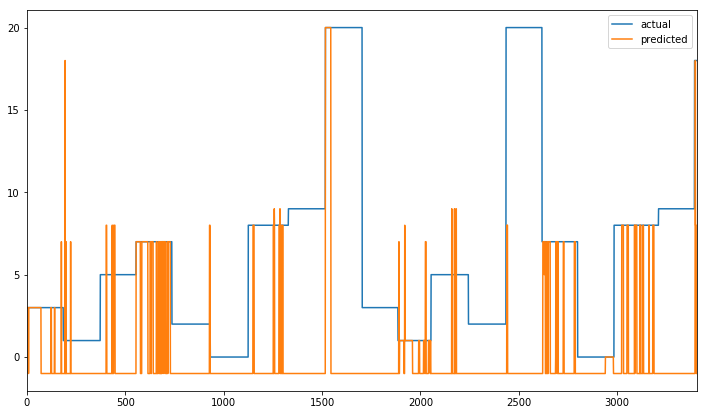

Synergy 2 coffee 0.990740740741


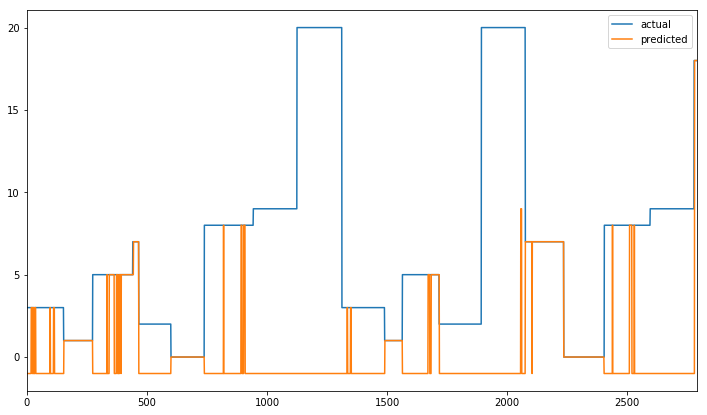

Scott 1 left 0.87852494577


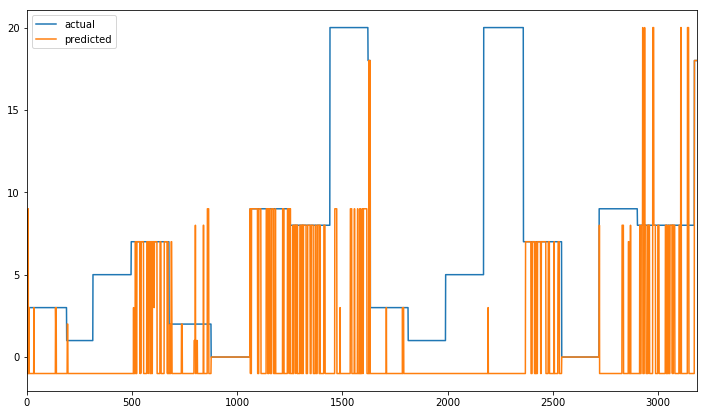

Synergy 1 table 0.900692840647


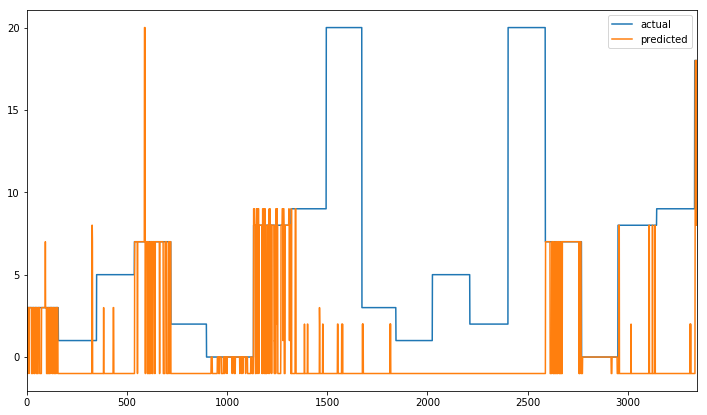

Robotics entrance 0.906107566089


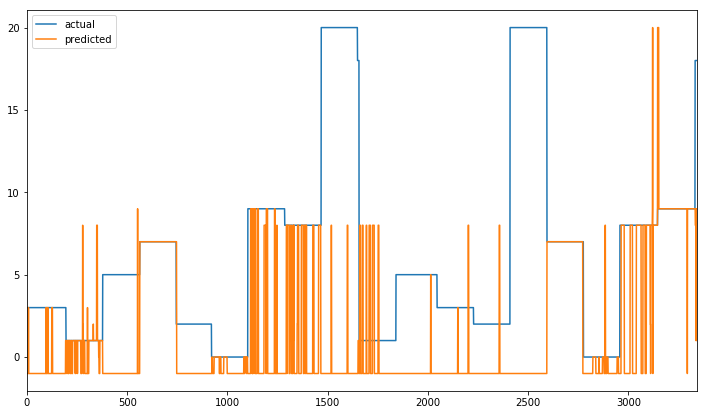

In [115]:
for test_name in test_results:
    all_predictions = test_results[test_name]
    df = all_predictions.loc[all_predictions.predicted != -1]
    print(test_name, accuracy_score(df['actual'], df['predicted']))
    all_predictions.plot()
    plt.show()

In [70]:
predicted = []
for row in results.values:
    predictions = [i for i in row if i != -1]
    if len(predictions) > 0:
        accuracies = [label_pipelines[p]['accuracy'] for p in predictions]
        i = np.argmax(accuracies)
        prediction = predictions[i]
        if label_pipelines[prediction]['accuracy'] >= 0.9:
            predicted.append(prediction)
            continue

    predicted.append(-1)

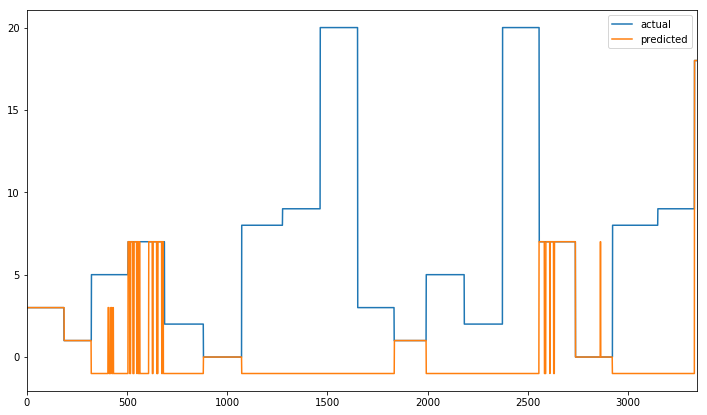

In [96]:
all_predictions = pd.DataFrame({'predicted': smooth_predictions(predicted),
                                'actual': df_target_labels['label'].values})

all_predictions.plot()

In [97]:
df = all_predictions.loc[all_predictions.predicted != -1]
accuracy_score(df['actual'], df['predicted'])

0.9843614248479583

In [94]:
for label in label_pipelines:
    pipeline = label_pipelines[label]['pipeline']
    print(pipeline.label_name, pipeline.source_name)

Dishes Synergy 1 sink
Microwave Synergy 1 sink
Coffee Robotics coffee
Null Robotics coffee
Phone vibrating Robotics coffee
Kettle Robotics coffee
Chopping food Scott 1 left
Conversation Robotics coffee
Eating popcorn Robotics coffee
Knocking Synergy 1 sink


[{'a': 1}, {'a': 2}]